# Computer Vision 2019-2020
**Prof. Luigi Di Stefano**  
luigi.distefano@unibo.it

Master Degree in Artificial Intelligence  
DISI - University of Bologna, Bologna

**Project name**  
Visual Inspection of Motorcycle Connecting Rods  
**Student**  
Alessandro Lombardi  
alessandro.lombardi5@studio.unibo.it

In [1]:
# import libraries
import numpy as np
from matplotlib import pyplot as plt
import cv2
import math

%matplotlib inline

## Task 1

In [2]:
# file names of the task 1
task1_image_filenames = [
    "TESI00.BMP",
    "TESI01.BMP",
    "TESI12.BMP",
    "TESI21.BMP",
    "TESI31.BMP",
    "Tesi33.bmp"]

In [3]:
# the index of the array corresponding to the chosen image, that will be used in next cells
index = 3

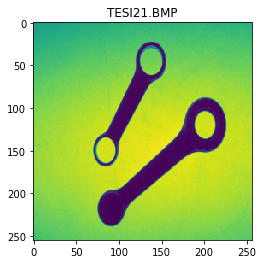

In [4]:
# read the image and store it
image = cv2.imread("../data/" + task1_image_filenames[index], cv2.IMREAD_GRAYSCALE)
plt.imshow(image)
plt.title(task1_image_filenames[index])
plt.show()

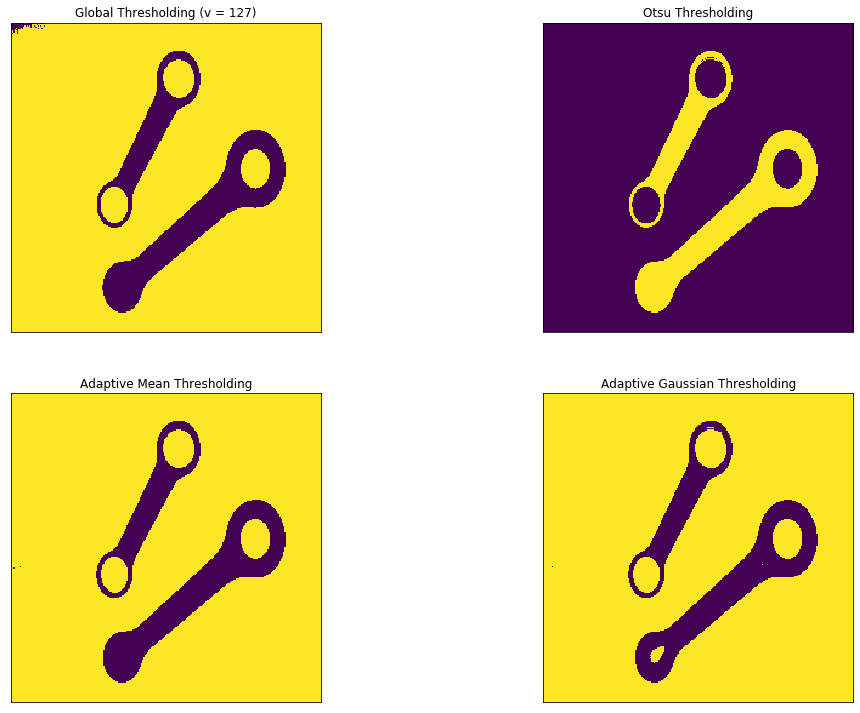

In [5]:
# try out different segmentation techniques to choose the proper one
binay_threshold = 127
ret_binary, th_binary = cv2.threshold(image, binay_threshold, 255, cv2.THRESH_BINARY)
ret_otsu, th_otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
th_mean = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 47, 14)
th_gaussian = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 47, 14)

titles = ['Global Thresholding (v = ' + str (binay_threshold) + ')', 'Otsu Thresholding', 'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [th_binary, th_otsu, th_mean, th_gaussian]

# plot them to make comparisons
plt.figure(figsize=(17.5, 12.5))

for i, img in enumerate(images):
    plt.subplot(2,2,i+1)
    plt.imshow(img)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

From previous images it's possible to observe that with variation on the background the global thresholding doesn't handle correctly the segmentation. Both the Adaptive Mean and Gaussian Thresholding must be tuned to reduce the intensity of noise on the background, in addition the Adaptive Gaussian shows some problems, creating holes inside the rods. The Otsu Thresholding is the most promising, because only in one sample provides a small imprecise and jagged contour that may cause some troubles later, for this reason, a closing followed by a opening is needed.

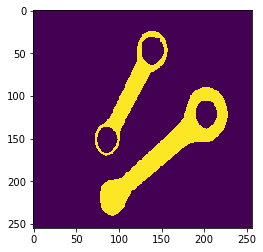

In [6]:
# close and open to remove small holes
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (2,2))
th_otsu = cv2.morphologyEx(cv2.morphologyEx(th_otsu, cv2.MORPH_CLOSE, kernel), cv2.MORPH_OPEN, kernel)
plt.imshow(th_otsu)
plt.show()

In [7]:
def mn_moment(data, m, n):
    ''' Measure the moments of the image given the order m and n
    Inputs:
        data - the binary image
        m - order of the vertical axis
        n - order of the horizontal axis
    Output:
        the moment
    '''
    if data is None or m is None or n is None:
        raise ValueError("Missing some required arguments")
    
    nrows, ncols = data.shape
    y_indices, x_indices = np.mgrid[:nrows, :ncols]
    return (data * x_indices ** m * y_indices ** n).sum()


In [8]:
def moments_cov(data, centroid):
    ''' Create the covariance matrix containing the moments up to second order
    Inputs:
        data - the binary image
        centroid - the centroid coordinate
    Output:
        cov - the covariance matrix containing the moments
    '''
    if data is None or centroid is None:
        raise ValueError("Missing some required arguments")
    
    m10 = mn_moment(data, 1, 0)
    m01 = mn_moment(data, 0, 1)
    m00 = mn_moment(data, 0, 0)
    u11 = (mn_moment(data, 1, 1) - centroid[0] * m01) / m00
    u20 = (mn_moment(data, 2, 0) - centroid[0] * m10) / m00
    u02 = (mn_moment(data, 0, 2) - centroid[1] * m01) / m00
    cov = np.array([[u20, u11], [u11, u02]])
    return cov

In [9]:
def contact_points(data, major_equation, minor_equation):
    ''' Find the contact points between major and minor axes parallel lines and the contour of the object 
    and measure the width at the barycentre
    Inputs:
        data - the binary image
        major_equation - list of type [a, b, c] representing the equation of the major axis
        major_equation - list of type [a, b, c] representing the equation of the minor axis
    Outputs:
        c1 - on major axis, negative
        c2 - on major axis, positive
        c3 - on minor axis, negative
        c4 - on minor axis, positive
        barycentre_width - the width at the barycentre
    '''
    if data is None or major_equation is None or minor_equation is None:
        raise ValueError("Missing some required arguments")
    
    # set maximum and minimum values to values easy to be changed in first iterations
    min_major_distance = math.inf
    max_major_distance = -math.inf
    min_minor_distance = math.inf
    max_minor_distance = -math.inf
    c1 = None
    c2 = None
    c3 = None
    c4 = None    
    min_barycentre_distance = math.inf
    max_barycentre_distance = -math.inf

    # for each point in the image, consider that coordinates could be misleading, moving in columns means changing the horizontal coordiante and vice vers
    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            if data[y,x] == 255:
                # distance from the major axis as distance of a point to a line
                major_distance = (major_equation[1] * y + major_equation[0] * x + major_equation[2]) / math.sqrt((major_equation[0] ** 2) + (major_equation[1] ** 2))
                # distance from the minor axis as distance of a point to a line
                minor_distance = (minor_equation[1] * y + minor_equation[0] * x + minor_equation[2]) / math.sqrt((minor_equation[0] ** 2) + (minor_equation[1] ** 2))
                
                # update contact points looking at extremum horizontal and vertical values found so far
                if major_distance < min_major_distance:
                    min_major_distance = major_distance
                    c1 = [x, y]
                if major_distance > max_major_distance:
                    max_major_distance = major_distance 
                    c2 = [x, y]
                if minor_distance < min_minor_distance:
                    min_minor_distance = minor_distance
                    c3 = [x, y]
                if minor_distance > max_minor_distance:
                    max_minor_distance = minor_distance
                    c4 = [x, y]
                
                # if the point is close to the minor axes then it is considered in computing the width at the barycentre
                if abs(minor_distance) < 0.75:
                    # the distances are computed on both directions and summed as the final value
                    if major_distance < min_barycentre_distance:
                        min_barycentre_distance = major_distance
                    if major_distance > max_barycentre_distance:
                        max_barycentre_distance = major_distance
    
    return c1, c2, c3, c4, abs(min_barycentre_distance) + abs(max_barycentre_distance)

In [10]:
def line_intersection(p1, p2, m1, m2):
    ''' Intersect 2 lines given 2 points and the associated slopes 
    Inputs:
        p1 - first point of first line [x,y]
        p2 - fist point of second line [x,y]
        m1 - slope of first line
        m2 - slope of second line
    Outputs:
        res - the intersection of the two lines if possible, array on np.nan otherwise
        
    '''
    if p1 is None or p2 is None or m1 is None or m2 is None:
        raise ValueError("Missing some required arguments")

    # prepare the matrices to solve the linear system of equations to find the intersection if there is
    a = np.array([[-m1, 1],
                  [-m2, 1]])
    b = np.array([p1[1] - m1 * p1[0], p2[1] - m2 * p2[0]])
    try:
        res = np.linalg.solve(a, b)
    except:
        res = np.array([np.nan, np.nan])

    return res

In [11]:
def main(image): 

    # find rods as connected components using a specific connectivity value  
    rod_connectivity = 4

    # rod_num, is the number of rods
    # rod_labelled_image, is the original image where each pixel is sunstituted by the correct label
    # rod_info, contains some informations about the blobs, as the area
    # rod_centroids, contains the centroid of each blob
    rod_num, rod_labelled_image, rod_info, rod_centroids = cv2.connectedComponentsWithStats(image, rod_connectivity, cv2.CV_32S)
    labels = np.unique(rod_labelled_image)
    print("Labels {}".format(rod_num))
    
    # consider as a background the blob with maximum area
    background_label = np.argmax(rod_info[:,4])

    # rods is a list of dictionaries containing the requested information for each rod
    rods = []

    # for each label, so rod
    for label in labels:
        # exclude background
        if label != background_label:
            rod = {"index":label}
            rods.append(rod)
            
            if rod_info[label][4] < 30:
                continue

            rods[-1]["area"] = rod_info[label][4]
            rods[-1]["centroid"] = rod_centroids[label]

            # create a binary image from the original one considering the labelled image: only the current rod will have the foreground value
            rod_image = th_otsu.copy()
            rod_image[rod_labelled_image == label] = 255
            rod_image[rod_labelled_image != label] = 0

            # create a binary image from the binary of the rod as its negative: only the holes of the current rod will have the foreground value
            hole_image = rod_image + 255
            hole_image[hole_image != 255] = 0        

            # find holes as connected components
            hole_connectivity = 4
            hole_num, hole_labelled_image, hole_info, hole_centroids = cv2.connectedComponentsWithStats(hole_image, hole_connectivity, cv2.CV_32S)

            ## Possible use of
            ## circularity = (Perimeter .^ 2) ./ (4 * pi * area);

            # by default the rods are classified as A
            rods[-1]["type"] = "A"
            rods[-1]["hole"] = []

            # exclude background
            hole_background_index = np.argmax(hole_info[:,4])

            # iterating the holes if two are found then the rod is labelled as B, if more an error is raised
            for index, area in enumerate(np.sort(hole_info[:,4])):
                if index > 1 and hole_background_index != index:
                    rods[-1]["hole"].append({"diameter":math.sqrt((area / math.pi)) * 2, "centre":hole_centroids[index]})
                    if index - 2 == 1:
                        rods[-1]["type"] = "B"
                    elif index - 2 > 1:
                        raise Exception("Error too many holes in a single rod index {}".format(index))
                        print("OK")


            if rods[-1]["hole"] == []:
                 raise Exception("Error too few holes in a single rod index")

            # use covariance matrix to find major and minor axes
            cov = moments_cov(rod_image, rods[-1]["centroid"])
            eigenvalues, eigenvectors = np.linalg.eig(cov)
            sort_indices = np.argsort(eigenvalues)[::-1]
            major_axes = eigenvectors[:, sort_indices[0]]
            minor_axes = eigenvectors[:, sort_indices[1]]

            #alpha = -math.sin(theta)
            #beta  =  math.cos(theta)
            alpha = major_axes[1]
            beta = major_axes[0]

            # find theta
            theta = abs(-0.5 * math.atan2((2 * cov[0,1]), (cov[0,0] - cov[1,1])))
            rods[-1]["angle"] = math.degrees(theta)

            # store major and minor equations
            major_equation = [alpha, -beta, beta * rods[-1]["centroid"][1] - alpha * rods[-1]["centroid"][0]]
            minor_equation = [beta, alpha, -beta * rods[-1]["centroid"][0] - alpha * rods[-1]["centroid"][1]]

            # find contact points and width at the barycentre
            c1, c2, c3, c4, rods[-1]["bw"] = contact_points(rod_image, major_equation, minor_equation)

            # compute MER vertices
            v1 = line_intersection(c1, c3, -major_equation[0] / major_equation[1], -minor_equation[0] / minor_equation[1])
            v2 = line_intersection(c1, c4, -major_equation[0] / major_equation[1], -minor_equation[0] / minor_equation[1])
            v3 = line_intersection(c2, c3, -major_equation[0] / major_equation[1], -minor_equation[0] / minor_equation[1])
            v4 = line_intersection(c2, c4, -major_equation[0] / major_equation[1], -minor_equation[0] / minor_equation[1])

            # measure length and width
            rods[-1]["length"] = math.sqrt(((v1[0] - v2[0])**2) + ((v1[1] - v2[1])**2))
            rods[-1]["width"] = math.sqrt(((v1[0] - v3[0])**2) + ((v1[1] - v3[1])**2))

            # Draw        
            # MER
            plt.plot([v1[0], v2[0]], [v1[1], v2[1]], color="#0000ff") #blue
            plt.plot([v2[0], v4[0]], [v2[1], v4[1]], color="#ff0000") #red
            plt.plot([v3[0], v1[0]], [v3[1], v1[1]], color="#c932c1") #purple
            plt.plot([v4[0], v3[0]], [v4[1], v3[1]], color="#00ff00") #green

            # Major and minor axes
            scale = 20
            plt.plot([major_axes[0] * -scale * 2 + rods[-1]["centroid"][0], major_axes[0] * scale * 2 + rods[-1]["centroid"][0]],
                     [major_axes[1] * -scale * 2 + rods[-1]["centroid"][1], major_axes[1] * scale * 2 + rods[-1]["centroid"][1]], color='black')
            plt.plot([minor_axes[0] * -scale + rods[-1]["centroid"][0], minor_axes[0] * scale + rods[-1]["centroid"][0]],
                     [minor_axes[1] * -scale + rods[-1]["centroid"][1], minor_axes[1] * scale + rods[-1]["centroid"][1]], color='black')
            plt.imshow(rod_image)
            plt.show()
            print(rods[-1])

Labels 3


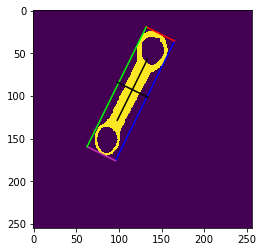

{'index': 1, 'area': 2480, 'centroid': array([115.67580645,  92.51048387]), 'type': 'B', 'hole': [{'diameter': 56.19282935520513, 'centre': array([139.23111782,  46.75075529])}, {'diameter': 280.0267912925556, 'centre': array([ 85.98911071, 151.15063521])}], 'angle': 63.71077298301027, 'bw': 18.784906259651795, 'length': 156.5660026137144, 'width': 37.11614541874661}


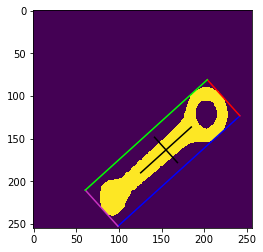

{'index': 2, 'area': 5285, 'centroid': array([155.07076632, 163.15553453]), 'type': 'A', 'hole': [{'diameter': 274.9519921161698, 'centre': array([202.18548387, 121.15645161])}], 'angle': 42.14490176340804, 'bw': 22.599329570573673, 'length': 192.90619388420376, 'width': 57.02483553857228}


In [12]:
main(th_otsu)

## Task 2

### Change 3

In [13]:
# file names of the task 2 powder
task2c_image_filenames = [
    "TESI90.BMP",
    "TESI92.BMP",
    "TESI98.BMP"]

task2c_image_rods_per_image = 3

In [23]:
index = 2


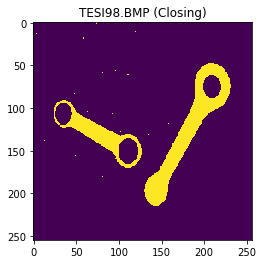

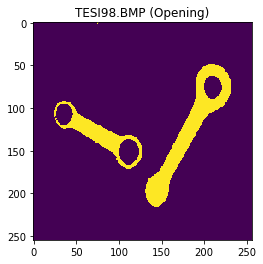

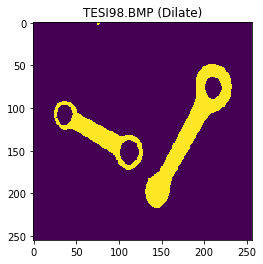

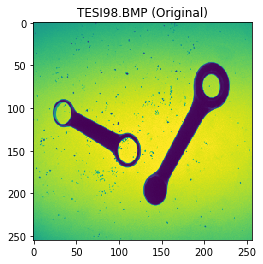

In [24]:
task2c_image = cv2.imread("../data/" + task2c_image_filenames[index], cv2.IMREAD_GRAYSCALE)

# segmentation
task2c_ret_otsu, task2c_th_otsu = cv2.threshold(task2c_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# close it
task2c_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (2,2))

task2c_th_otsu = cv2.morphologyEx(task2c_th_otsu, cv2.MORPH_CLOSE, task2c_kernel)
plt.title(task2c_image_filenames[index] + " (Closing)")
plt.imshow(task2c_th_otsu)
plt.show()

# then open it
task2c_th_otsu = cv2.morphologyEx(task2c_th_otsu, cv2.MORPH_OPEN, task2c_kernel)
plt.title(task2c_image_filenames[index] + " (Opening)")
plt.imshow(task2c_th_otsu)
plt.show()

# and finally dilate it
task2c_dilation_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
task2c_th_otsu = cv2.dilate(task2c_th_otsu, task2c_dilation_kernel, iterations = 1)
plt.title(task2c_image_filenames[index] + " (Dilate)")
plt.imshow(task2c_th_otsu)
plt.show()

plt.imshow(task2c_image)
plt.title(task2c_image_filenames[index] + " (Original)")
plt.show()

Labels 4


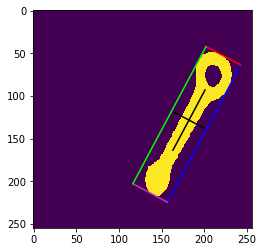

{'index': 2, 'area': 4198, 'centroid': array([182.03096713, 128.19556932]), 'type': 'A', 'hole': [{'diameter': 277.9685985363335, 'centre': array([210.09823678,  76.17884131])}], 'angle': 61.93359795227123, 'bw': 18.35289734301142, 'length': 182.3536398274814, 'width': 46.057099059805665}


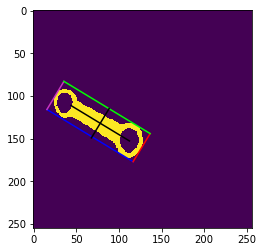

{'index': 3, 'area': 2091, 'centroid': array([ 77.98373984, 131.92300335]), 'type': 'B', 'hole': [{'diameter': 51.597905849377504, 'centre': array([ 36.45086705, 107.89595376])}, {'diameter': 281.7628530038543, 'centre': array([112.14285714, 151.63877551])}], 'angle': 31.196219727388243, 'bw': 19.721479153917265, 'length': 118.1956473223383, 'width': 38.563902317173785}


In [25]:
main(task2c_th_otsu)

Opening and closing has a general good effect in removing small particles but using an aggressive strategy has the drawback of corrupting the rods' circles, which are essential for finding the rod's type. A possible solution is to open the image with a small kernel to remove small particles, dilate the whole image a bit to close possible broken circles and use a threshold value to ignore the small remaining areas.

### Change 1

### Change 2